In [1]:
from keras.models import Model, load_model, model_from_json
import keras
from keras.datasets import cifar10, mnist
from keras import regularizers, callbacks
import sys
sys.path.append('C:/Users/320060820/Documents/prep_experiments/model_quantization')
from train_model import *
from inception_model import get_model
import copy

import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
import math

from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
TRAIN = True
save_path = '../../saved models/'
num_classes = 10
epochs = 30
reduced_training_size_factor = 10
batch_size = 64

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

train_data, test_data = (x_train, y_train), (x_test, y_test)

if TRAIN:
    kernels = [20, 16, 32, 64]
    model = get_model(input_shape=(96, 96, 1), nb_classes=10, 
                              nb_fabrics=49, scale_factor=96//96, nb_inception_modules=3,
                              resampling='conv', kernels=kernels, reg=None, batch_norm=True, pool_layer='average')
    train_data, test_data, trained_model, history = train_model(
                    model, train_data, test_data, epochs, 
                    batch_size, num_classes, reduced_training_size_factor, rgb=False, lr=0.001)
    
    trained_model.save(save_path + 'mnist_original/v3_batchnorm.h5')
    x_train_resize, y_train = train_data
    x_test_resize, y_test = test_data

else:
    num_classes = 10
    reduced_training_size_factor = 10
    batch_size = 64
    training_data, testing_data = mnist.load_data()
    _, (x_test_resize, y_test) = convert_data(train_data, test_data, batch_size, num_classes, 
                                               reduced_training_size_factor)
    model = load_model(save_path + 'v3_original_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 6000 samples, validate on 1000 samples
Epoch 1/30
6000/6000 [==============================] - 13s 2ms/step - loss: 0.9090 - acc: 0.7508 - val_loss: 1.7232 - val_acc: 0.5450
Epoch 2/30
6000/6000 [==============================] - 9s 2ms/step - loss: 0.2440 - acc: 0.9457 - val_loss: 0.9700 - val_acc: 0.7070
Epoch 3/30
6000/6000 [==============================] - 9s 2ms/step - loss: 0.1292 - acc: 0.9693 - val_loss: 2.6952 - val_acc: 0.3510
Epoch 4/30
6000/6000 [==============================] - 9s 2ms/step - loss: 0.0783 - acc: 0.9848 - val_loss: 6.6783 - val_acc: 0.2570
Epoch 5/30
6000/6000 [==============================] - 9s 2ms/step - loss: 0.0482 - acc: 0.9917 - val_loss: 4.1108 - val_acc: 0.2530
Epoch 6/30
6000/6000 [==============================] - 9s 2ms/step - loss: 0.0293 - acc: 0.9955 - val_loss: 2.7396 - val_acc: 0.6510
Epoch 7/30
6000/6000 [=====

In [32]:
def get_kernel_weights(model):
    """
    Get all coefficients of the convolutional kernels
    """
    weights_list = [model.layers[1].get_weights()[0].flatten(), model.layers[1].get_weights()[1].flatten()]
    
    for layer in model.layers[2:]:
        if layer.weights and 'kernel' in layer.weights[0].name:
            weights_list[0] = np.append(weights_list[0], layer.get_weights()[0].flatten())
            weights_list[1] = np.append(weights_list[1], layer.get_weights()[1].flatten())
    
    return weights_list

In [33]:
all_weights = get_kernel_weights(model)

Text(0.5, 1.0, 'Biases')

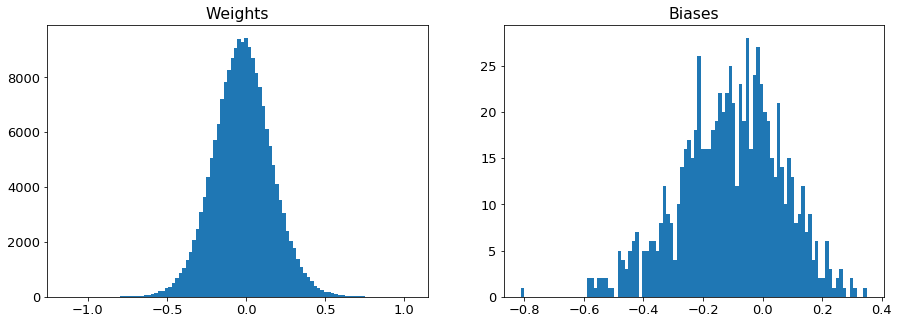

In [34]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
plt.hist(all_weights[0], bins=100);
plt.title('Weights')

fig.add_subplot(1, 2, 2)
plt.hist(all_weights[1], bins=100);
plt.title('Biases')

In [35]:
def clip_all_weights(model, threshold, biases=True):
    
    for layer in model.layers[1:]:
        if layer.weights and 'kernel' in layer.weights[0].name:
            weights = layer.get_weights()
            weights[0] = np.clip(weights[0], -threshold, threshold)
            if biases:
                weights[1] = np.clip(weights[1], -threshold, threshold)
            layer.set_weights(weights)
    
    return model

In [36]:
def clip_biases(model, threshold):
    
    for layer in model.layers[1:]:
        if layer.weights and 'kernel' in layer.weights[0].name:
            weights = layer.get_weights()
            weights[1] = np.clip(weights[1], -threshold, threshold)
            layer.set_weights(weights)
    
    return model

In [37]:
w_clip_scores = []
b_clip_scores = []
bo_clip_scores = []

w_clip_model = copy.deepcopy(model)
b_clip_model = copy.deepcopy(model)
bo_clip_model = copy.deepcopy(model)

for c in np.arange(1.0, 0.1, -0.05):
    w_clip_model = clip_all_weights(w_clip_model, c, False)
    b_clip_model = clip_all_weights(b_clip_model, c, True)
    bo_clip_model = clip_biases(bo_clip_model, c)
    
    w_clip_scores.append(w_clip_model.evaluate(x_test_resize, y_test, verbose=0))
    b_clip_scores.append(b_clip_model.evaluate(x_test_resize, y_test, verbose=0))
    bo_clip_scores.append(bo_clip_model.evaluate(x_test_resize, y_test, verbose = 0))

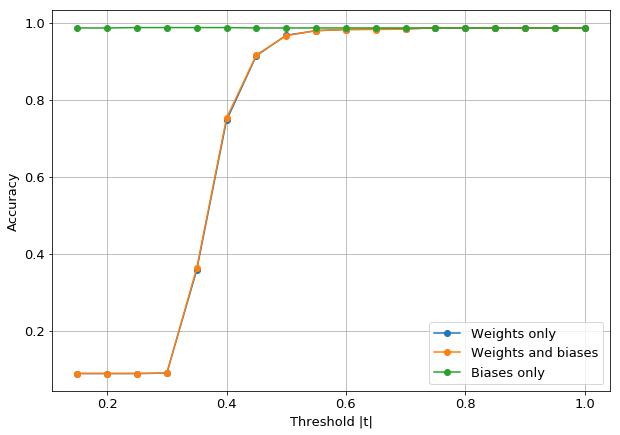

In [38]:
wclip = np.array(w_clip_scores).T
bclip = np.array(b_clip_scores).T
boclip = np.array(bo_clip_scores).T

plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, 0.1, -0.05), wclip[1], 'o-',label='Weights only');
plt.plot(np.arange(1, 0.1, -0.05), bclip[1], 'o-', label='Weights and biases');
plt.plot(np.arange(1, 0.1, -0.05), boclip[1], 'o-', label='Biases only');
plt.xlabel('Threshold |t|')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

Including biases while clipping the weights does not affect inference accuracy. Hence weights and biases can be jointly quantized. 

## Fixed-point rounding

In [39]:
def round_to_fixed_point(float_numbers, fractional_bits):
    '''
    Rounds numbers to their fixed-point representation.
    '''
    integer_value = np.around(float_numbers * (2 ** fractional_bits))
    return integer_value / (2 ** fractional_bits)


def quantize_weights_to_fxp(model, fractional_bits, biases=True):
    '''
    Quantizes weights of a NN model to fixed-point representation. Does not include biases or the BN layer
    '''
    for layer in model.layers:
        if layer.weights and 'kernel' in layer.weights[0].name:
            weights_of_layer = layer.get_weights()
            weights_of_layer[0] = round_to_fixed_point(weights_of_layer[0], fractional_bits)
            if biases:
                weights_of_layer[1] = round_to_fixed_point(weights_of_layer[1], fractional_bits)
            layer.set_weights(weights_of_layer)
    
    return model

In [40]:
def quantize_biases(model, fractional_bits):
    for layer in model.layers:
        if layer.weights and 'kernel' in layer.weights[0].name:
            weights_of_layer = layer.get_weights()
            weights_of_layer[1] = round_to_fixed_point(weights_of_layer[1], fractional_bits)
            layer.set_weights(weights_of_layer)
    
    return model

In [41]:
w_fxp_scores = []
b_fxp_scores = []
bo_fxp_scores = []

w_fxp_model = copy.deepcopy(model)
b_fxp_model = copy.deepcopy(model)
bo_fxp_model = copy.deepcopy(model)

for i in np.arange(8, 0, -1):
    w_fxp_model = quantize_weights_to_fxp(w_fxp_model, i, biases=False)
    b_fxp_model = quantize_weights_to_fxp(b_fxp_model, i, biases=True)
    bo_fxp_model = quantize_biases(bo_fxp_model, i)
    
    w_fxp_scores.append(w_fxp_model.evaluate(x_test_resize, y_test, verbose=0))
    b_fxp_scores.append(b_fxp_model.evaluate(x_test_resize, y_test, verbose=0))
    bo_fxp_scores.append(bo_fxp_model.evaluate(x_test_resize, y_test, verbose=0))

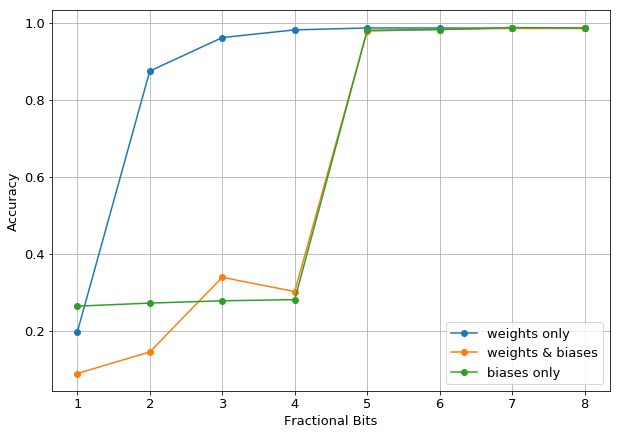

In [42]:
ww = np.array(w_fxp_scores).T
bb = np.array(b_fxp_scores).T
bo = np.array(bo_fxp_scores).T

plt.figure(figsize=(10, 7))
plt.plot(np.arange(8, 0, -1), ww[1], 'o-', label='weights only');
plt.plot(np.arange(8, 0, -1), bb[1], 'o-', label='weights & biases');
plt.plot(np.arange(8, 0, -1), bo[1], 'o-', label='biases only')
plt.xlabel('Fractional Bits')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()